# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импортируем необходимые для работы библиотеки и инструменты:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import warnings
warnings.filterwarnings('ignore') # команда-блокиратор предупреждений

Загрузим данные и ознакомимся с ними:

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
display(data.sample(5))
data.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2947,2948,15793813,Onochie,774,France,Male,36,7.0,103688.19,1,0,1,118971.74,0
8722,8723,15718667,T'ien,621,France,Male,35,7.0,87619.29,1,1,0,143.34,0
5692,5693,15662662,Duigan,573,France,Female,30,6.0,0.00,2,1,0,66190.21,0
7119,7120,15636478,Williams,621,France,Male,31,7.0,136658.61,1,1,1,148689.13,0
1843,1844,15769346,Baird,587,France,Female,36,1.0,134997.49,2,1,0,44688.08,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Определим объем работы по подготовке полученных данных:
- данные столбцов RowNumber, CustomerId, Surname не несут полезной информации, можем их удалить;
- пропущенных значений в столбце Tenure (сколько лет человек является клиентом банка) немного, чуть менее 10%, можем их заменить на 0;
- категориальные значения столбцов Geography, Gender преобразуем в количественные методом OHE;
- разобьем данные на 3 выборки: тренировочную, валидационную и тестовую в соотношении 3:1:1;
- проведем масштабирование признаков всех 3-ех выборок

In [3]:
# удаляем ненужные столбцы
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns', inplace=True)

# заменяем пропуски на 0
data['Tenure'] = data['Tenure'].fillna(0).astype('int64')

# преобразуем категориальные признаки в количественные 
data_ohe = pd.get_dummies(data, drop_first=True)

Целевой признак в задаче - Exited, в соответствии с этим создадим переменные target и features и разобьем данные на 3 выборки: 

In [4]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

features_train, features_rest, target_train, target_rest = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_rest, target_rest, test_size=0.5, random_state=12345)

Проверим соотношение получившихся выборок:

In [5]:
print("Обучающая часть:", features_train.shape)
print("Валидационная часть:", features_valid.shape)
print("Тестовая часть:", features_test.shape)

Обучающая часть: (6000, 11)
Валидационная часть: (2000, 11)
Тестовая часть: (2000, 11)


Масштабируем признаки методом стандартизации:

In [6]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Этап подготовки завершен, данные готовы для дальнейшего использования.

## Исследование задачи

Проведем обучение моделей, поочередно задействуя модели "Дерево решений", "Случайный лес" и "Логистическая регрессия": 

### "Дерево решений"

Для проверки этой модели реализуем через цикл перебор значений max_depth от 1 до 30 и отберем лучшее значение по параметру F1:

In [7]:
f1_best = 0
depth_best = 0
for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > f1_best:
            f1_best = f1
            depth_best = depth
print(f"F1 наилучшей модели на валидационной выборке: ~ {f1_best:.5f}")
print("Оптимальная глубина дерева:", depth_best) 

F1 наилучшей модели на валидационной выборке: ~ 0.57865
Оптимальная глубина дерева: 9


Подсчитаем значения accuracy, precision, recall и AUC_ROC по полученным гиперпараметрам:

In [8]:
model = DecisionTreeClassifier(random_state=12345, max_depth=depth_best)
model.fit(features_train, target_train)
prediction = model.predict(features_valid)
print(f"Accuracy ~ {accuracy_score(target_valid, prediction):.5f}")
print(f"Precision ~ {precision_score(target_valid, prediction):.5f}")
print(f"Recall ~ {recall_score(target_valid, prediction):.5f}")
print(f"AUC-ROC ~ {roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]):.5f}")

Accuracy ~ 0.85000
Precision ~ 0.70068
Recall ~ 0.49282
AUC-ROC ~ 0.78997


### "Случайный лес"

Для проверки этой модели реализуем через цикл перебор значений n_estimators от 1 до 100 и max_depth от 1 до 30, отберем лучшее значение по параметру F1:

*P.S. В конечном коде сократил длину циклов для уменьшения времени работы ядра*

In [9]:
f1_best = 0
est_best = 0
depth_best = 0
for est in range (43, 44):
    for depth in range(12, 13):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        prediction = model.predict(features_valid)
        f1 = f1_score(target_valid, prediction)
        if f1 > f1_best:
            f1_best = f1
            est_best = est
            depth_best = depth
             
print(f"F1 наилучшей модели на валидационной выборке: ~ {f1_best:.5f}")
print("Оптимальное количество деревьев:", est_best)         
print("Оптимальная глубина дерева:", depth_best)   

F1 наилучшей модели на валидационной выборке: ~ 0.59760
Оптимальное количество деревьев: 43
Оптимальная глубина дерева: 12


Подсчитаем значения accuracy, precision, recall и AUC_ROC по полученным гиперпараметрам:

In [10]:
model = RandomForestClassifier(n_estimators=est_best, max_depth=depth_best, random_state=12345)
model.fit(features_train, target_train)
prediction = model.predict(features_valid)
print(f"Accuracy ~ {accuracy_score(target_valid, prediction):.5f}")
print(f"Precision ~ {precision_score(target_valid, prediction):.5f}")
print(f"Recall ~ {recall_score(target_valid, prediction):.5f}")
print(f"AUC-ROC ~ {roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]):.5f}")

Accuracy ~ 0.86600
Precision ~ 0.80242
Recall ~ 0.47608
AUC-ROC ~ 0.84210


### "Логистическая регрессия"

Гиперпараметры этой модели настраивать не нужно, инициализируем модель, обучим её и подсчитаем значения F1, accuracy, precision, recall и AUC_ROC:

In [11]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
prediction = model.predict(features_valid)
print(f"F1 ~ {f1_score(target_valid, prediction):.5f}")
print(f"Accuracy ~ {accuracy_score(target_valid, prediction):.5f}")
print(f"Precision ~ {precision_score(target_valid, prediction):.5f}")
print(f"Recall ~ {recall_score(target_valid, prediction):.5f}")
print(f"AUC-ROC ~ {roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]):.5f}")

F1 ~ 0.33390
Accuracy ~ 0.80250
Precision ~ 0.56571
Recall ~ 0.23684
AUC-ROC ~ 0.75863


**ВЫВОД:**
- Наиболее удачным показала себя модель "Случайного леса" с гиперпараметрами n_estimators=43, max_depth=12, показатель F1 оказался чуть выше заданных 0,59
- Показатель recall у всех моделей оказался значительно ниже precision, что влияет на значение F1
- Такое расхождение указывает на несбалансированность данных, следует это выяснить и максимально возможно уравновесить значения, вероятно в результате удастся достичь более высоких показателей F1

## Борьба с дисбалансом

Исследуем целевой признак на баланс данных:

0    7963
1    2037
Name: Exited, dtype: int64

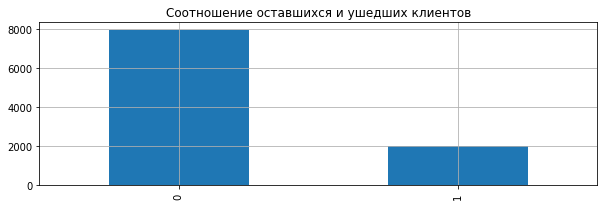

In [12]:
data_ohe['Exited'].value_counts().plot(kind='bar', grid=True, figsize=(10, 3),title='Соотношение оставшихся и ушедших клиентов')
data_ohe['Exited'].value_counts()

В данных наблюдается очевидный дисбаланс, соотношение 4:1. Попробуем поэксперементировать с балансом данных при помощи различных инструментов (class_weight='balanced', Upsampling, Downsampling) с целью повысить значение показателя F1:

### Параметр автоматической регулировки весов (class_weight)

#### "Дерево решений"

In [13]:
f1_best = 0
depth_best = 0
for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > f1_best:
            f1_best = f1
            depth_best = depth
print(f"F1 наилучшей модели на валидационной выборке: ~ {f1_best:.5f}")
print("Оптимальная глубина дерева:", depth_best) 

F1 наилучшей модели на валидационной выборке: ~ 0.59638
Оптимальная глубина дерева: 5


#### "Случайный лес"

In [14]:
f1_best = 0
est_best = 0
depth_best = 0
for est in range (79, 80):
    for depth in range(8, 9):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        prediction = model.predict(features_valid)
        f1 = f1_score(target_valid, prediction)
        if f1 > f1_best:
            f1_best = f1
            est_best = est
            depth_best = depth
             
print(f"F1 наилучшей модели на валидационной выборке: ~ {f1_best:.5f}")
print("Оптимальное количество деревьев:", est_best)         
print("Оптимальная глубина дерева:", depth_best)   

F1 наилучшей модели на валидационной выборке: ~ 0.62227
Оптимальное количество деревьев: 79
Оптимальная глубина дерева: 8


#### "Логистическая регрессия"

In [15]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
prediction = model.predict(features_valid)
print(f"F1 ~ {f1_score(target_valid, prediction):.5f}")

F1 ~ 0.48889


**ВЫВОД:**

Использование параметра автоматической регулировки весов позволил увеличить показатель F1 у всех моделей, однако лучше всего, как и в предыдущем пункте, себя показала модель "Случайный лес", удалось повысить **F1** до **~ 0.63676**

### Метод Upsampling (увеличение выборки)

Напишем собственную функцию для увеличение выборки:

In [16]:
def upsample(features, target, repeat):
    # Разделяем выборку по значениям целевой функции
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # Увеличиваем и соединяем обратно
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # Перемешиваем
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Используем функцию для увеличения выборки в 4 раза и проверим их соотношение:

In [17]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(features_upsampled.shape[0])
print(target_upsampled.shape[0])

9588
9588


Теперь воспользуемся полученными выборками и проведем обучение моделей:

#### "Дерево решений"

In [18]:
f1_best = 0
depth_best = 0
for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > f1_best:
            f1_best = f1
            depth_best = depth
print(f"F1 наилучшей модели на валидационной выборке: ~ {f1_best:.5f}")
print("Оптимальная глубина дерева:", depth_best) 

F1 наилучшей модели на валидационной выборке: ~ 0.59638
Оптимальная глубина дерева: 5


#### "Случайный лес"

In [19]:
f1_best = 0
est_best = 0
depth_best = 0
for est in range (57, 58):
    for depth in range(13, 14):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        prediction = model.predict(features_valid)
        f1 = f1_score(target_valid, prediction)
        if f1 > f1_best:
            f1_best = f1
            est_best = est
            depth_best = depth
             
print(f"F1 наилучшей модели на валидационной выборке: ~ {f1_best:.5f}")
print("Оптимальное количество деревьев:", est_best)         
print("Оптимальная глубина дерева:", depth_best)   

F1 наилучшей модели на валидационной выборке: ~ 0.63260
Оптимальное количество деревьев: 57
Оптимальная глубина дерева: 13


#### "Логистическая регрессия"

In [20]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
prediction = model.predict(features_valid)
print(f"F1 ~ {f1_score(target_valid, prediction):.5f}")

F1 ~ 0.48889


**ВЫВОД:**

Метод Upsampling позволил увеличить показатели значений F1 разных моделей, но превзойти результат параметра class_weight не удалось.

### Метод Downsampling (уменьшение выборки)

Напишем собственную функцию для уменьшения выборки:

In [21]:
def downsample(features, target, fraction):
    # Разделяем выборку по значениям целевой функции
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # Случайным образом убираем часть из отрицательных объектов
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    # Перемешиваем
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Используем функцию для уменьшения выборки, проверим соотношение:

In [22]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print(features_downsampled.shape[0])
print(target_downsampled.shape[0])

2397
2397


Теперь воспользуемся полученными выборками и проведем обучение моделей:

#### "Дерево решений"

In [23]:
f1_best = 0
depth_best = 0
for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction)
    if f1 > f1_best:
            f1_best = f1
            depth_best = depth
print(f"F1 наилучшей модели на валидационной выборке: ~ {f1_best:.5f}")
print("Оптимальная глубина дерева:", depth_best) 

F1 наилучшей модели на валидационной выборке: ~ 0.59312
Оптимальная глубина дерева: 5


#### "Случайный лес"

In [24]:
f1_best = 0
est_best = 0
depth_best = 0
for est in range (24, 25):
    for depth in range(7, 8):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        prediction = model.predict(features_valid)
        f1 = f1_score(target_valid, prediction)
        if f1 > f1_best:
            f1_best = f1
            est_best = est
            depth_best = depth
             
print(f"F1 наилучшей модели на валидационной выборке: ~ {f1_best:.5f}")
print("Оптимальное количество деревьев:", est_best)         
print("Оптимальная глубина дерева:", depth_best)   

F1 наилучшей модели на валидационной выборке: ~ 0.60133
Оптимальное количество деревьев: 24
Оптимальная глубина дерева: 7


#### "Логистическая регрессия"

In [25]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
prediction = model.predict(features_valid)
print(f"F1 ~ {f1_score(target_valid, prediction):.5f}")

F1 ~ 0.48927


**ВЫВОД:**

Метод Downsampling, как и Upsampling, позволил увеличить первоначальные показатели F1, но превзойти результат параметра class_weight не удалось.

В конечном результате выберем модель **"Случайный лес"** с параметром автоматической регулировки весов (class_weight) и гиперпараметрами n_estimators=79 и max_depth=8, благодаря которой удалось достичь наибольшего результата **F1 ~ 0.63676**.

## Тестирование модели

Для проведения финального обучения можно объединить выборки target_train и target_valid, features_train и features_valid, дабы модель получила больше данных и смогла достичь лучшего качества:

In [26]:
target_united = pd.concat([target_train, target_valid], axis=0)
features_united = pd.concat([features_train, features_valid], axis=0)

Обучим финальную модель и проверим ее на тестовой выборке:

In [27]:
model = RandomForestClassifier(n_estimators=79, max_depth = 8, random_state=12345, class_weight='balanced')
model.fit(features_united, target_united)
prediction = model.predict(features_test)
print(f"F1 на тестовой выборке ~ {f1_score(target_test, prediction):.5f}")
if f1_score(target_test, prediction) > 0.59:
    print('Необходимое значение F1-меры достигнуто!')

F1 на тестовой выборке ~ 0.61951
Необходимое значение F1-меры достигнуто!


**Исследуем метрику AUC-ROC и построим ROC-кривую для финальной модели:**

In [28]:
print(f"AUC-ROC ~ {roc_auc_score(target_united, model.predict_proba(features_united)[:, 1]):.5f}")

AUC-ROC ~ 0.91808


<Figure size 432x288 with 0 Axes>

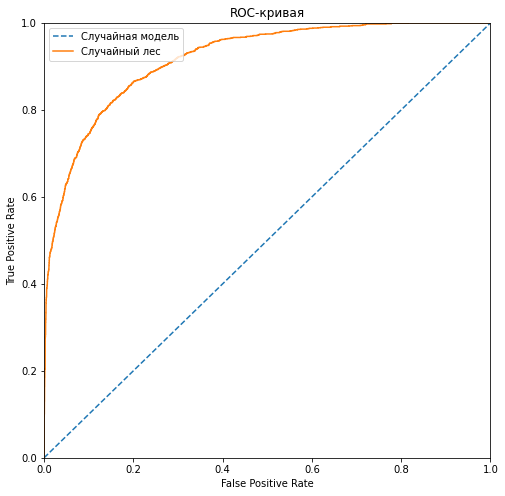

In [29]:
fpr, tpr, thresholds = roc_curve(target_united, model.predict_proba(features_united)[:, 1])

plt.figure()

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr,tpr)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Случайный лес'), loc= 'upper left') 

**ВЫВОД:**

1. Модель "Случайный лес" с подобранными гиперпараметрами и параметром "class_weight" позволила достичь значения F1-меры выше запрошенной, ~ 0.63676 на тестовой выборке;
2. Значение AUC-ROC  ~ 0.91763, близко к 1;
3. По графику ROC-кривой можно сказать, что качество полученной модели достаточно высокое;

ИТОГ - выбранная нами модель соответствует для решения поставленной задачи!